In [2]:
import scipy.io as io
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
def pca_mle(X, y, fig = True):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    
    pca = PCA(n_components='mle')
    X_new = pca.fit_transform(X)
    
    if fig:
        plt.plot(X_new[norm, 0], X_new[norm, 1], 'bo', label = 'Normal')
        plt.plot(X_new[anom, 0], X_new[anom, 1], 'r*', label = 'Anomaly')
        plt.legend()
        plt.show()

    return X_new, y

def cy(y):
    newy = y.copy()
    newy = newy.astype('int32')
    newy[np.argwhere(y == 1)] = -1
    newy[np.argwhere(y == 0)] = int(1)
    newy = newy.flatten()
    newy = newy.flatten()
    return newy


def limit_y(X, y, per):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    rp = np.array(np.random.permutation(np.size(anom)))
    anom = np.array(anom)
    norm = np.array(norm)
    num = int((per/(1-per)) * len(norm))
    newy = np.concatenate((y[norm], y[anom[rp[0:num]]]))
    newX = np.concatenate((X[norm, :], X[anom[rp[0:num]], :]))
    return newX, newy

def print_stats(est_y, newy):
    compare = sum(est_y == newy)
    anom = np.argwhere(newy == -1);
    fanom = est_y[anom] == newy[anom];
    found = float(sum(fanom)) / np.size(anom) * 100;

    print('Accuracy:', float(compare) / np.size(newy) * 100)
    print('\nF1 Score:', F1Calc(est_y, newy))
    print('\nPercent Anomalies Found:', found)
    
def F1Calc(est_y, y):
    out = np.argwhere(y == -1)
    tp = sum(est_y[out] == y[out])
    anom = np.size(out);
    pos = sum((est_y == -1));
    rec = float(tp) / anom;
    try:
        prec = float(tp) / pos;
        F1 = (2 * prec * rec) / (prec + rec);
    except ZeroDivisionError:
        F1 = 0
    return F1

def calc_stats(acc, f1, p_anom, prec, est_y, ytest):
    compare = sum(est_y == ytest)
    anom = np.argwhere(ytest == -1);
    fanom = est_y[anom] == ytest[anom];
    anomm = np.argwhere(est_y == -1)
    found = float(sum(fanom)) / np.size(anom) * 100;
    try:
        precc = float(sum(fanom)) / np.size(anomm) * 100;
    except ZeroDivisionError:
        precc = 0
    

    acc[i] = float(compare) / np.size(ytest) * 100
    f1[i] = F1Calc(est_y, ytest)
    p_anom[i] = found
    prec[i] = precc
    return [acc, f1, p_anom, prec]

def plotvar(n_est, acc, p_anom, prec, f1, rtime, method, variable, showtime):
    plt.plot(n_est, acc,label = 'Accuracy')
    plt.plot(n_est, p_anom,label = 'Percent Anomalies')
    plt.plot(n_est, prec, label = 'Precision')
    plt.plot(n_est, f1*100, label = 'F1')
    ind = np.argmax(f1)
    plt.plot(n_est[ind],f1[ind]*100, '*', label = 'Highest F1 Score')
    plt.legend()
    plt.title(method)
    plt.xlabel(variable)
    plt.show()
    if showtime:
        plt.figure()
        plt.plot(n_est, rtime)
        plt.ylabel('Time (s)')
        plt.xlabel(variable)
        plt.title('Run Time')
        plt.show()

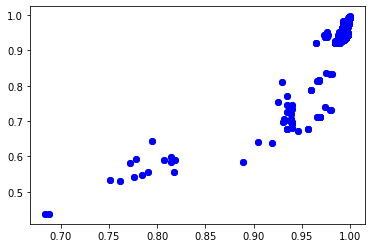

In [4]:
voldata = pd.read_csv('comparevolmass.csv')
X = np.concatenate((voldata[voldata.columns[1:19]].values[0:8395],voldata[voldata.columns[1:19]].values[8395:]), axis=0)
c = np.concatenate((voldata[voldata.columns[22]].values[0:8395],voldata[voldata.columns[22]].values[8395:]), axis=0)
plt.scatter(voldata[voldata.columns[20]], voldata[voldata.columns[21]], c='b',label = 'Correct')
plt.show()

In [5]:
# summarize class distribution
print(len(c))
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.4)
# fit and apply the transform
Xo, co = over.fit_resample(X, c)
print(len(co))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
Xf, cf = under.fit_resample(Xo, co)
# summarize class distribution
print(len(cf))
y = Xf[:,17]
X_f = Xf[:,:17]

16116
20552
17616


In [6]:
X_, y_ = limit_y(X_f, y, .10)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.2, random_state = 3)

In [8]:
newy_test = cy(y_test)
newy = cy(y_)
newy_train = cy(y_train)

In [9]:
clf = RandomForestClassifier()
clf.fit(X_train, newy_train)

RandomForestClassifier()

In [10]:
est_y = clf.predict(X_test)
print_stats(est_y, newy_test)

Accuracy: 83.11577752553916

F1 Score: 0.8268839103869654

Percent Anomalies Found: 82.13872832369941


Feature: 0, Score: 0.05367
Feature: 1, Score: 0.06204
Feature: 2, Score: 0.05354
Feature: 3, Score: 0.08383
Feature: 4, Score: 0.10905
Feature: 5, Score: 0.09331
Feature: 6, Score: 0.07871
Feature: 7, Score: 0.10007
Feature: 8, Score: 0.00100
Feature: 9, Score: 0.00047
Feature: 10, Score: 0.00137
Feature: 11, Score: 0.08043
Feature: 12, Score: 0.08259
Feature: 13, Score: 0.16612
Feature: 14, Score: 0.01096
Feature: 15, Score: 0.01140
Feature: 16, Score: 0.01145


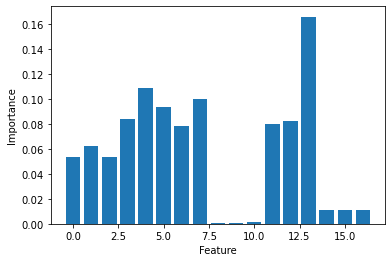

In [12]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
f = plt.figure()
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
f.savefig('featimportance.png', format='png', dpi=1200)


In [196]:
m = 100
n_est1 = np.linspace(10, 4000, m)
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = RandomForestClassifier()
    model.fit(X_train, newy_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

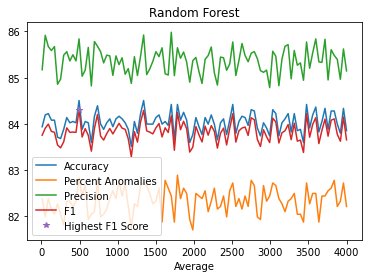

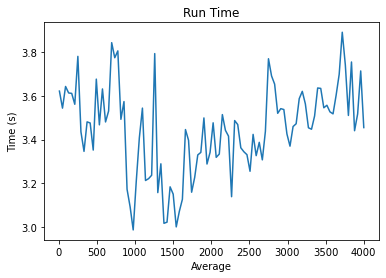

Highest F1 score recorded: 0.8431034482758623
Average F1 score: 0.8382942678493615
Standard Deviation: 0.002162178770777041
Average Runtime: 3.448250143809419


In [197]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Random Forest', 'Average',1)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind])
print('Average F1 score:',np.mean(f11))
print('Standard Deviation:',np.std(f11))
print('Average Runtime:', np.mean(rtime1))

In [198]:
m = 100
n_est3 = np.linspace(1, 100, m)
acc3 = np.zeros(m)
f13 = np.zeros(m)
p_anom3 = np.zeros(m)
time3 = np.zeros(m)
prec3 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    nov = LocalOutlierFactor(n_neighbors = int(n_est3[i]), novelty = True)
    nov.fit(X_train)
    est_ytest = nov.predict(X_test)
    stop = timeit.default_timer()
    
    [acc3, f13, p_anom3, prec3] = calc_stats(acc3, f13, p_anom3, prec3, est_ytest, newy_test)
    time3[i] = stop - start
   

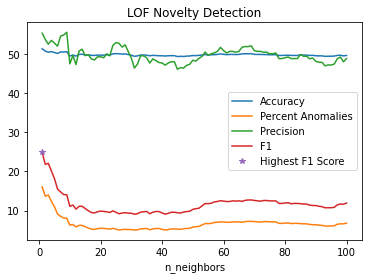

Highest F1 score recorded: 0.24857768052516416 at 1.0 n_neighbor


In [199]:
plotvar(n_est3, acc3, p_anom3, prec3, f13, time3, 'LOF Novelty Detection', 'n_neighbors',0)
ind = np.argmax(f13)
print('Highest F1 score recorded:',max(f13), 'at', n_est3[ind], 'n_neighbor')